# Multilevel Models

In this chapter, we'll see the formal version of this argument and how it leads us to MULTILEVEL MODELS. These models rememeber features of each cluster in the data as they learn about all of the clusters. Depending upon variation among clusters, which is learned from the data as well, the model pools information across clusters. This pooling tends to improve estimates about each cluster. This improved estimation sleads to several, more pragmatic sounding benefits of the multilevel approach.

- Improved estimates for repeat sampling. When more than one observation arises from the same individual, location, or time, then the traditional single-level models either maximally underfit or overfit the data.

- Improved estimates for imbalance in sampling. When some individuals, locations, or times are sampled more than others, multilevel models automatically cope with differing uncertainty across these clusters. This prevents over-sampled clusters from unfairly dominating inference

- Estimates of variation. If our research questions include variation among individuals or other groups within the data, then multilevel models are a big help, because they model variation expliciltly.

- Avoiding averaging, retain variation. Frequently, scholars pre-average some data to construct variables. This can be dangerous, because averaging removes variation, and there are also typically several different ways to perform the averaging. Averaging both manufactures false confidence and introduces arbitrary data transformations. Multilevel models allow us to preserve the uncertainty and avoid data transformations.

All of these benefits flow out of the same strategy and model structure. You learn one basic design and get all of this for free.



## Example - Multilevel Tadpoles

The hearwarming focus of this example are experiments exploring Reed frod tadpole mortality. The natural history background to this data is very interesting.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

from scipy import stats
from scipy.special import expit as logistic

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.credible_interval"] = 0.89
az.rcParams["stats.ic_scale"] = "deviance"
az.rcParams["stats.information_criterion"] = "waic"

In [3]:
d = pd.read_csv("reedfrogs.csv", sep=",")
print(d.shape)
d.head(8)

(48, 5)


,density,pred,size,surv,propsurv
0,10,no,big,9,0.9
1,10,no,big,10,1.0
2,10,no,big,7,0.7
3,10,no,big,10,1.0
4,10,no,small,9,0.9
5,10,no,small,9,0.9
6,10,no,small,10,1.0
7,10,no,small,9,0.9


For now, we'll be interested in the number surviving - surv - out of an intiial count, density. In the practice at the end of the chapter, you'll consider other variables, which are experimental manipulations.

There is a lot of variation in these data. Some of the variation comes from experimental treatment. But a lot of it comes from other sources. Think of each row as a 'tank' an experimental environment that contains tadpoles. There are lots of things peculiar to each tank that go unpeasured, and these umneasured factors create variation in survival across tanks, even when all the predictor variables have the same value. These tanks are an example of a cluster variable. Multiple oberssvations are made within each cluster.

So we have repeat measures and heterogeneity across clusters. If we ignore the clusters, assigning the same intercept to each of them, then we risk ignoring important variation in baseline survival. This variation could mask association with other variables. If we instead estimate a unique intercept for each cluster, using a dummy variable for each tank, we instead practice anterograde amnesia. After all, tanks are different but each tank does help us estimate survival in other tanks. So it doesn't make sense to forget entirely, moving from cluster to cluster.

A multilevel model, in which we simultaneously estimate both an intercept for each tank and the variation among tanks, is what we want. This will be a VARYING INTERCEPTS model. Varying intercepts are the simplest kind of VARYING EFFECTS. For each cluster in the data, we use a unique intercept parameter. This is no different than the categorical variable examples from previous chapters, except now we also adaptively learn the prior that is common to all of these intercepts.

Here is a model for predicting tadpole mortality in each tank, sing the regularising priors of earlier chapters.

S = Binomial(N,p)

logit(p) = alpha_Tank

alpha = Normal(0,1.5)

In [4]:
# Lets make this model in pymc3

tank = np.arange(d.shape[0])    # numbers 0-47 for each tank
n_tanks = d.shape[0]            # total numbers of tanks


with pm.Model() as m_13_1:
    a = pm.Normal("a", 0, 1.5, shape = n_tanks)      # remember we have 48 intercepts, one for each tank
                                                     # This prior puts the inverse logit in the middle 'on the slanty bit' - its suspicious
                                                     # of extreme values - i.e. its always/never going to happen
            
    p = pm.math.invlogit(a[tank])                    # This is the link function (48 of these because it flows from alpha)
                                                 # could this have worked just as well as a beta distribution - no need for the link function?
    
    S = pm.Binomial("S", n=d.density,p=p, observed = d.surv)
    
    trace_13_1 = pm.sample(random_seed = RANDOM_SEED)

az.summary(trace_13_1, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:11<00:00, 356.98draws/s] 


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],1.71,0.79,0.30,3.29,0.01,0.01,3676.70,2247.11,3951.80,1236.50,1.00
a[1],2.43,0.92,0.79,4.21,0.02,0.01,3666.40,2351.42,4276.79,1400.16,1.00
a[2],0.73,0.65,-0.46,2.01,0.01,0.01,4019.16,1296.83,4207.78,1167.11,1.00
a[3],2.39,0.92,0.81,4.23,0.01,0.01,4111.89,2760.24,4285.19,1374.99,1.00
a[4],1.71,0.75,0.37,3.18,0.01,0.01,3488.14,1935.27,3781.16,1122.79,1.00
a[5],1.72,0.82,0.25,3.30,0.01,0.01,3309.27,2064.16,3603.40,1325.53,1.00
a[6],2.40,0.90,0.77,4.15,0.01,0.01,4092.72,2555.67,4595.75,1420.70,1.00
a[7],1.70,0.74,0.36,3.14,0.01,0.01,3930.08,2424.62,4274.63,1471.57,1.00
a[8],-0.38,0.58,-1.50,0.71,0.01,0.01,3562.98,1098.87,3615.07,1300.14,1.00
a[9],1.72,0.79,0.31,3.23,0.01,0.01,3359.41,2156.49,3685.11,1304.46,1.01


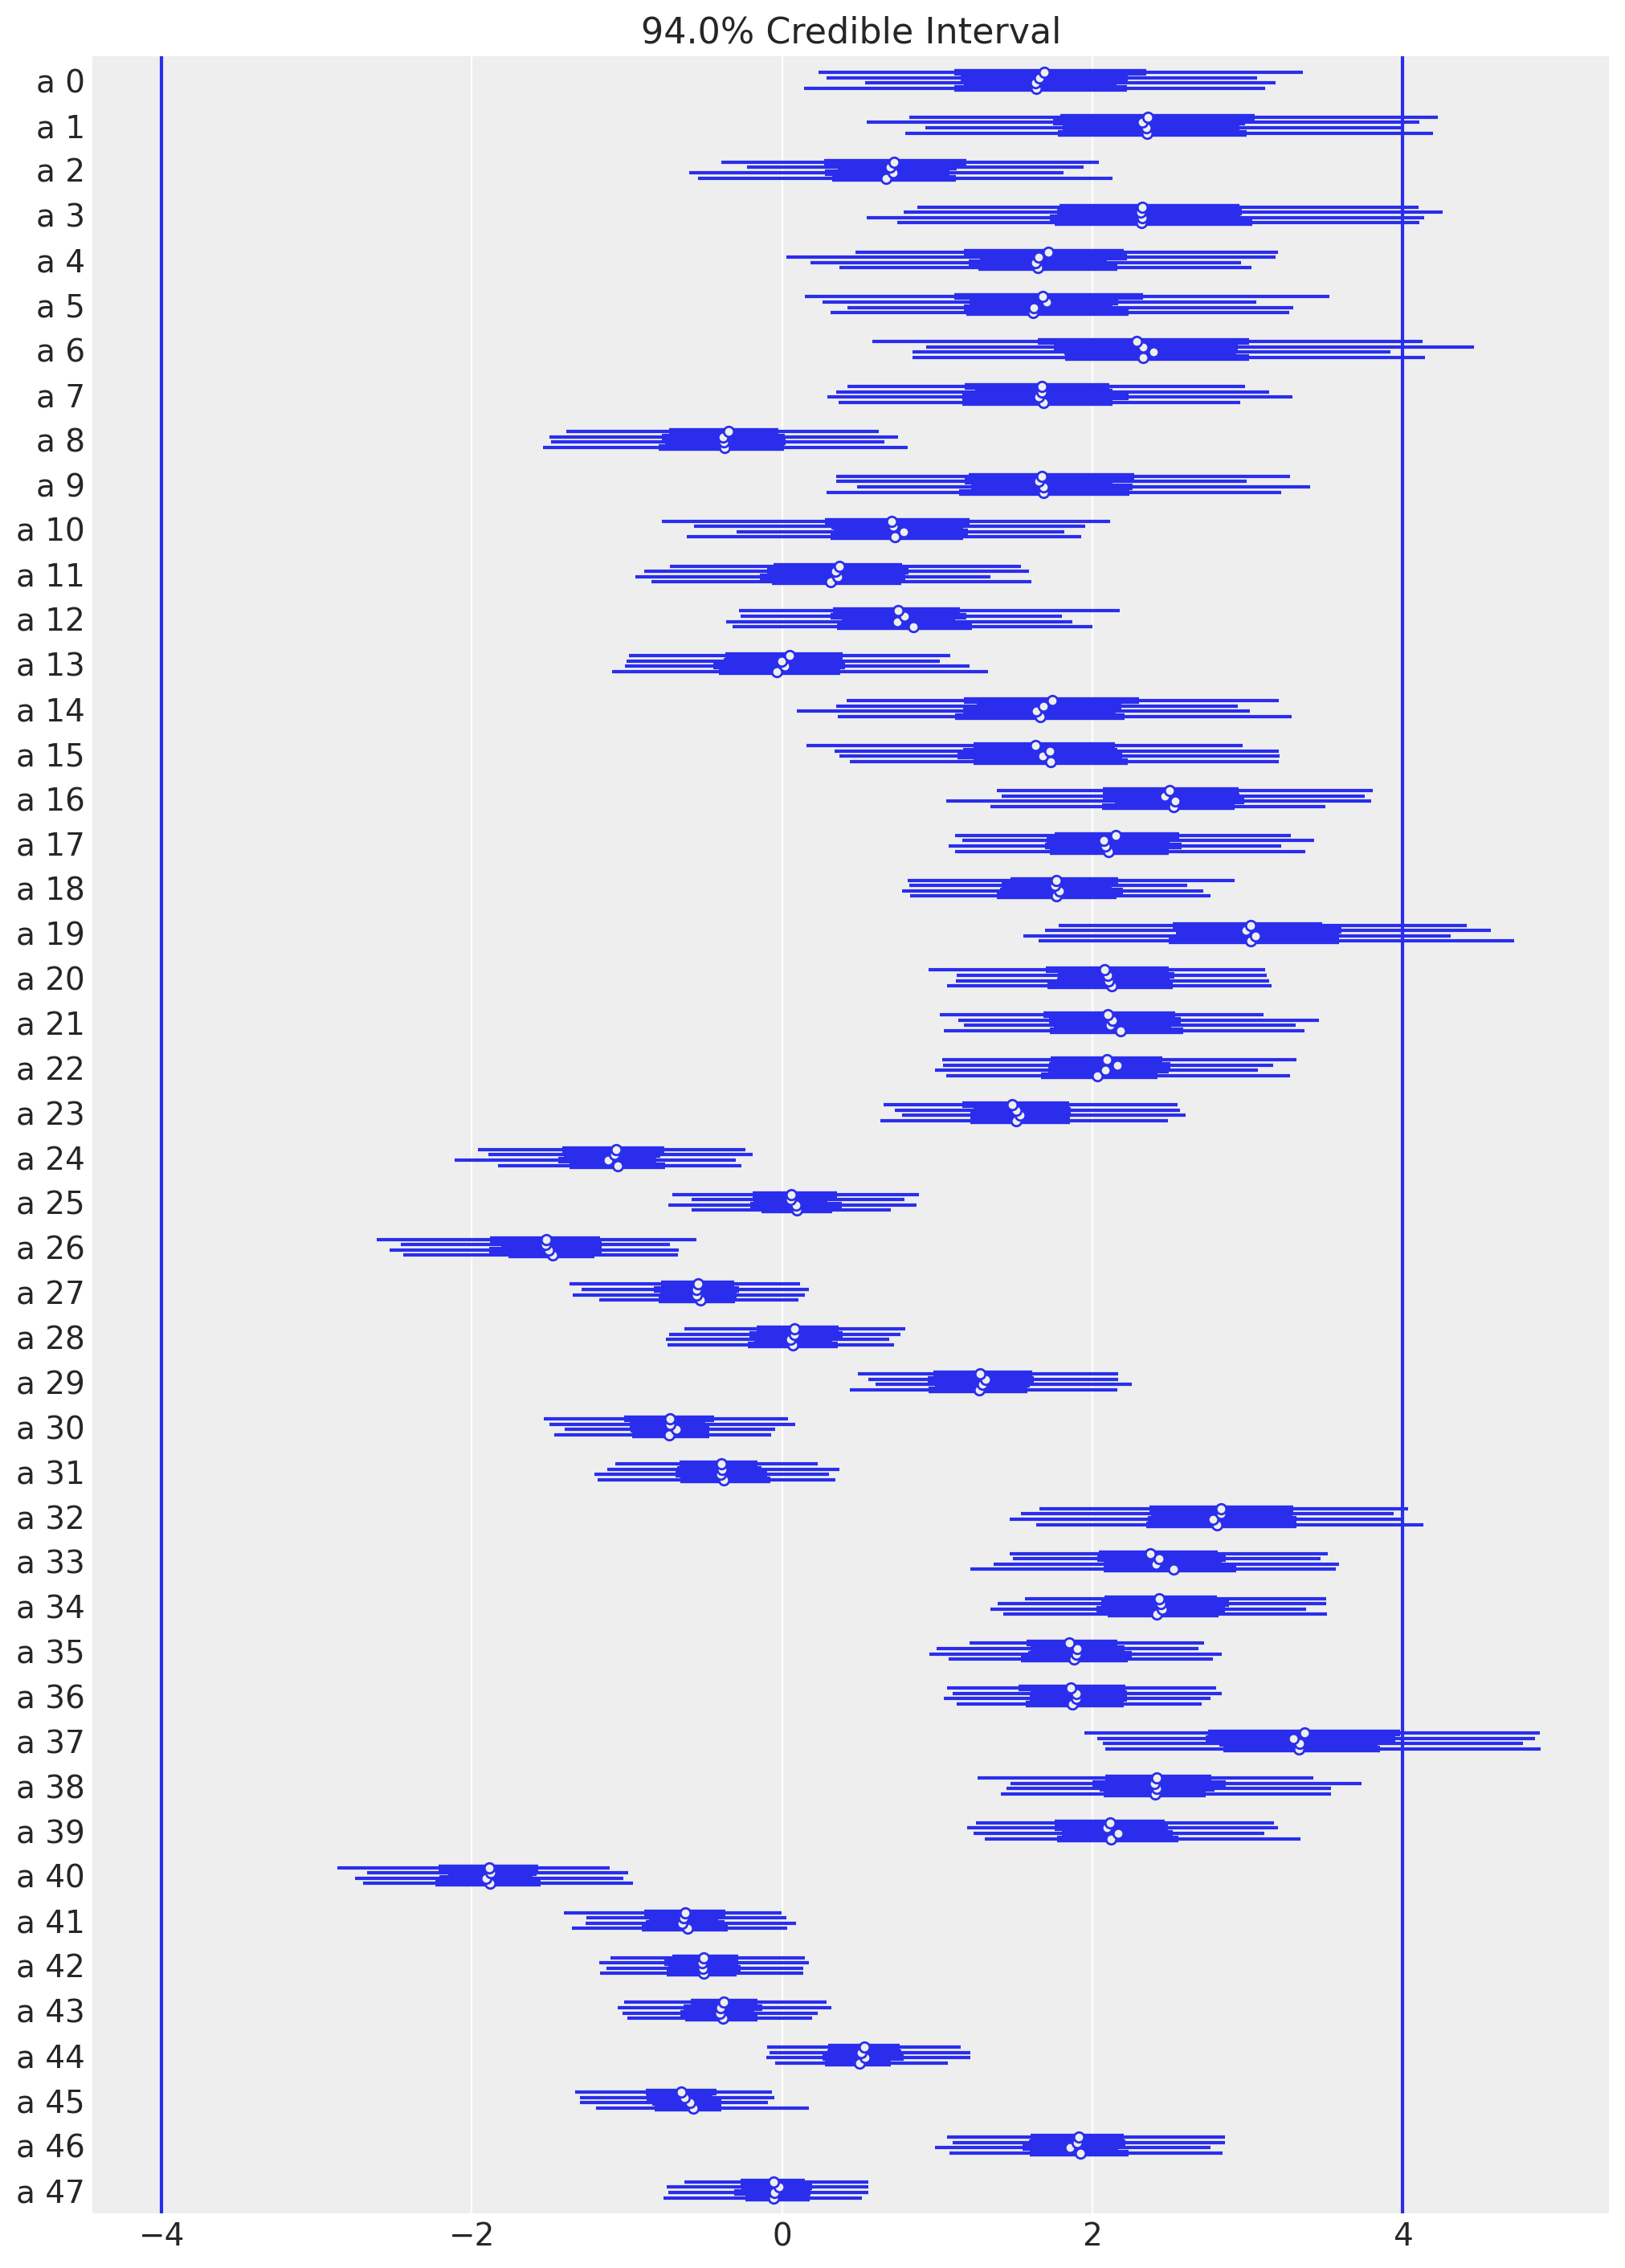

In [5]:
az.plot_forest(trace_13_1, figsize = (10,14))
plt.vlines([-4,4],-1000,1000)
plt.show()


Above, you'll see 48 different intercepts, one for each tank. To get each tanks expected survival probability, just take one of the values and then use the logistic transform to get the expected survival probability. As a little test lets do this for one of the tanks

In [6]:
np.shape(trace_13_1['a'][:,0])

(2000,)

Text(0.5, 1.0, 'Another view of survival probabilities in two tanks')

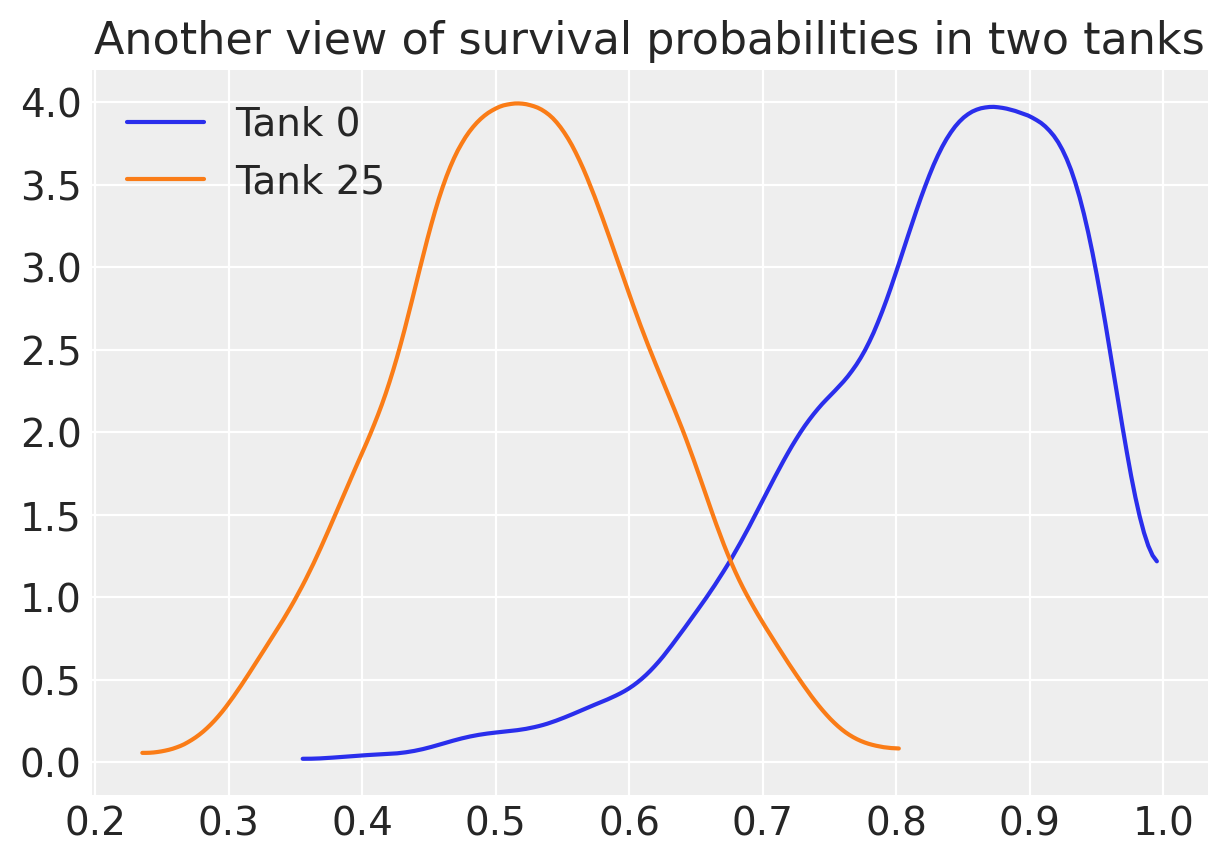

In [7]:
az.plot_dist(logistic(trace_13_1['a'][:,0]),label = 'Tank 0')
az.plot_dist(logistic(trace_13_1['a'][:,25]),label = 'Tank 25')
plt.title('Another view of survival probabilities in two tanks')

Now lets do the multilevel model, with adaptively pools information across tanks. All that is required to enable adaptive tooling is to make the prior for the parameter a function of some new parameters

In [8]:
with pm.Model() as m_13_2:
    
    # Highest Level Hyperpriors
    a_bar = pm.Normal("a_bar",0.5,2)
    sigma = pm.Exponential("sigma",1)
    
    # per tank prior - notice it takes the hyperpriors as an input
    a = pm.Normal("a", a_bar, sigma, shape=n_tanks)
    p = pm.math.invlogit(a[tank])
    
    S = pm.Binomial("S", n=d.density, p=p, observed=d.surv)
    
    trace_13_2 = pm.sample(random_seed = RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma, a_bar]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:04<00:00, 945.45draws/s] 


In [9]:
az.compare({"m13_1": trace_13_1, "m13_2": trace_13_2})

/Users/jopa/opt/anaconda3/envs/stats/lib/python3.8/site-packages/arviz/stats/stats.py:1194: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/jopa/opt/anaconda3/envs/stats/lib/python3.8/site-packages/arviz/stats/stats.py:1194: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m13_2,0,199.645720,20.800393,0.000000,0.994478,4.648335,0.000000,True,deviance
m13_1,1,213.527217,25.057872,13.881497,0.005522,7.545681,3.908549,True,deviance


In [10]:
az.summary(trace_13_2, var_names=['a_bar','sigma'],round_to=2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a_bar,1.37,0.26,0.94,1.91,0.01,0.0,2257.35,2147.57,2259.89,1507.51,1.0
sigma,1.62,0.21,1.24,2.01,0.01,0.0,1309.81,1301.55,1310.42,1597.54,1.0


/Users/jopa/opt/anaconda3/envs/stats/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/jopa/opt/anaconda3/envs/stats/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/jopa/opt/anaconda3/envs/stats/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/jopa/opt/anaconda3/envs/stats/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/jopa/opt/anaconda3/envs/stats/lib/python3.8/site-packages

array([[<AxesSubplot:title={'center':'a_bar'}>,
        <AxesSubplot:title={'center':'a_bar'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

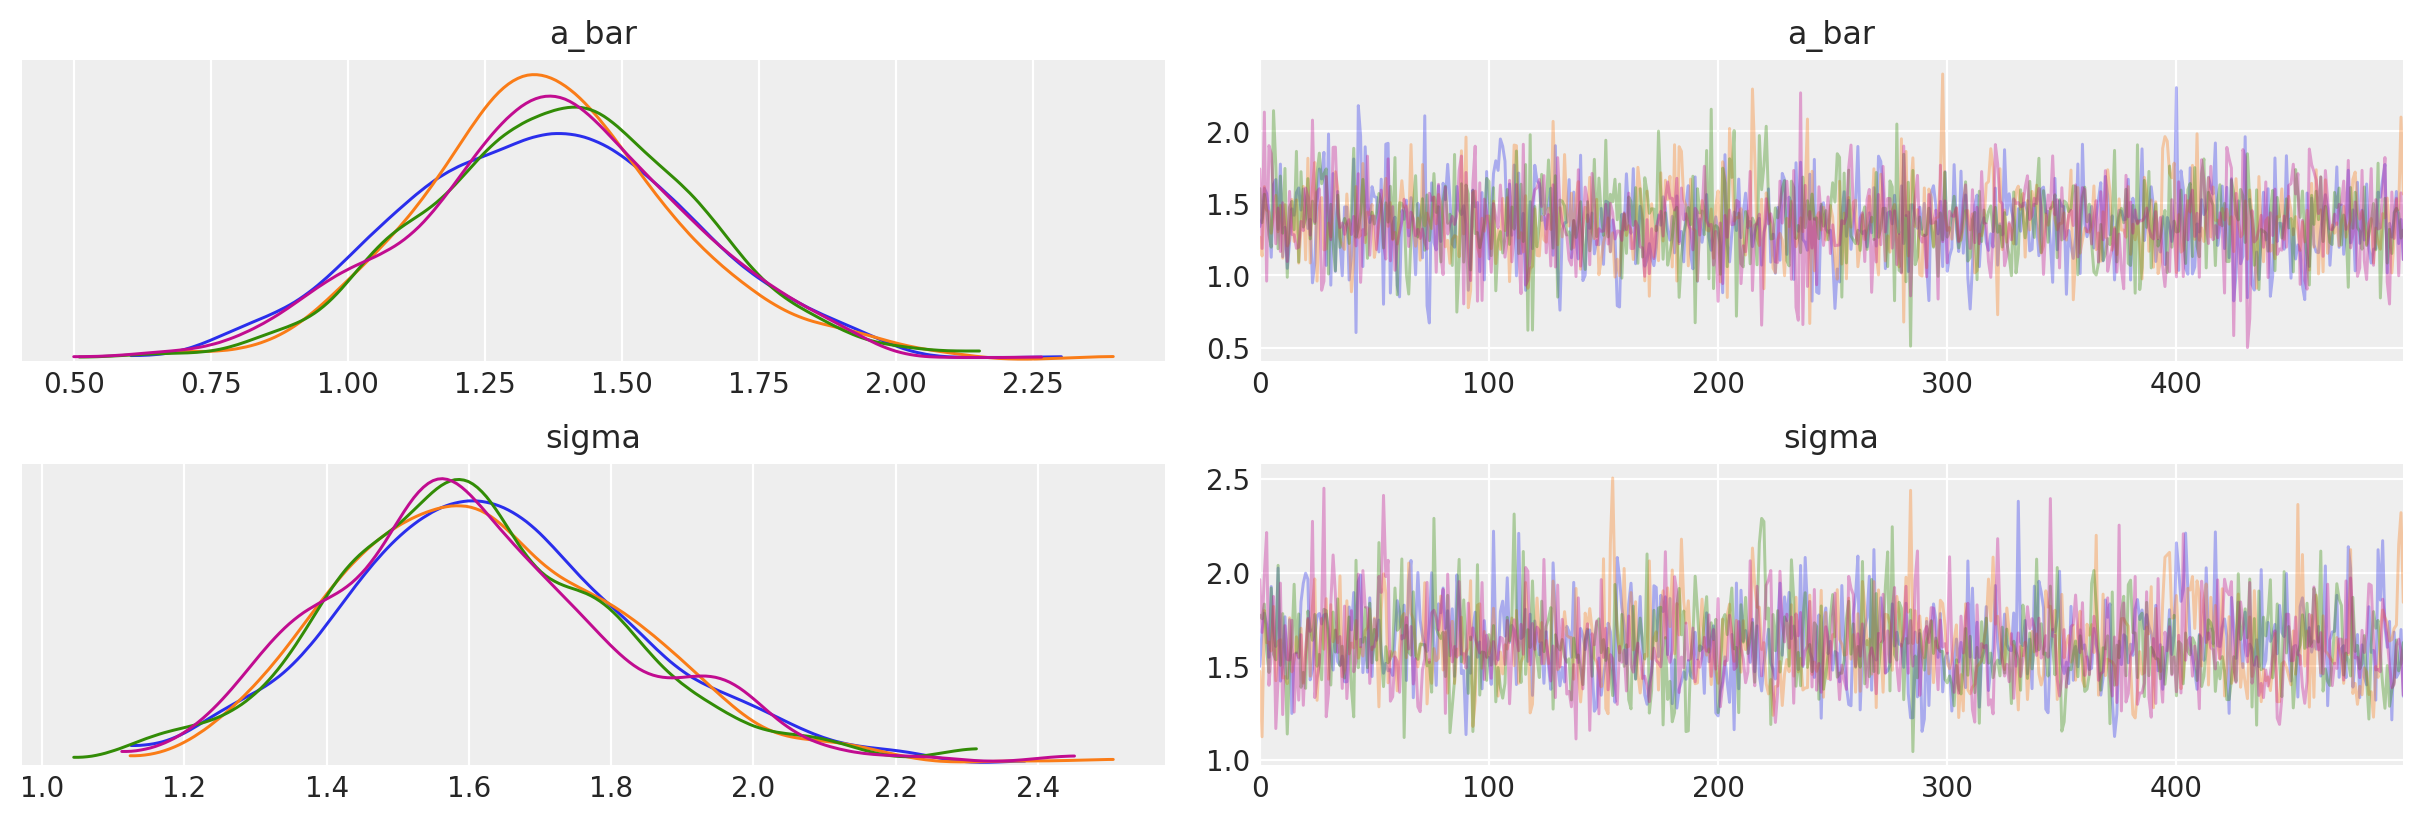

In [11]:
az.plot_trace(trace_13_2, var_names=['a_bar','sigma'])

Text(0.5, 1.0, 'Another view of survival probabilities in two tanks')

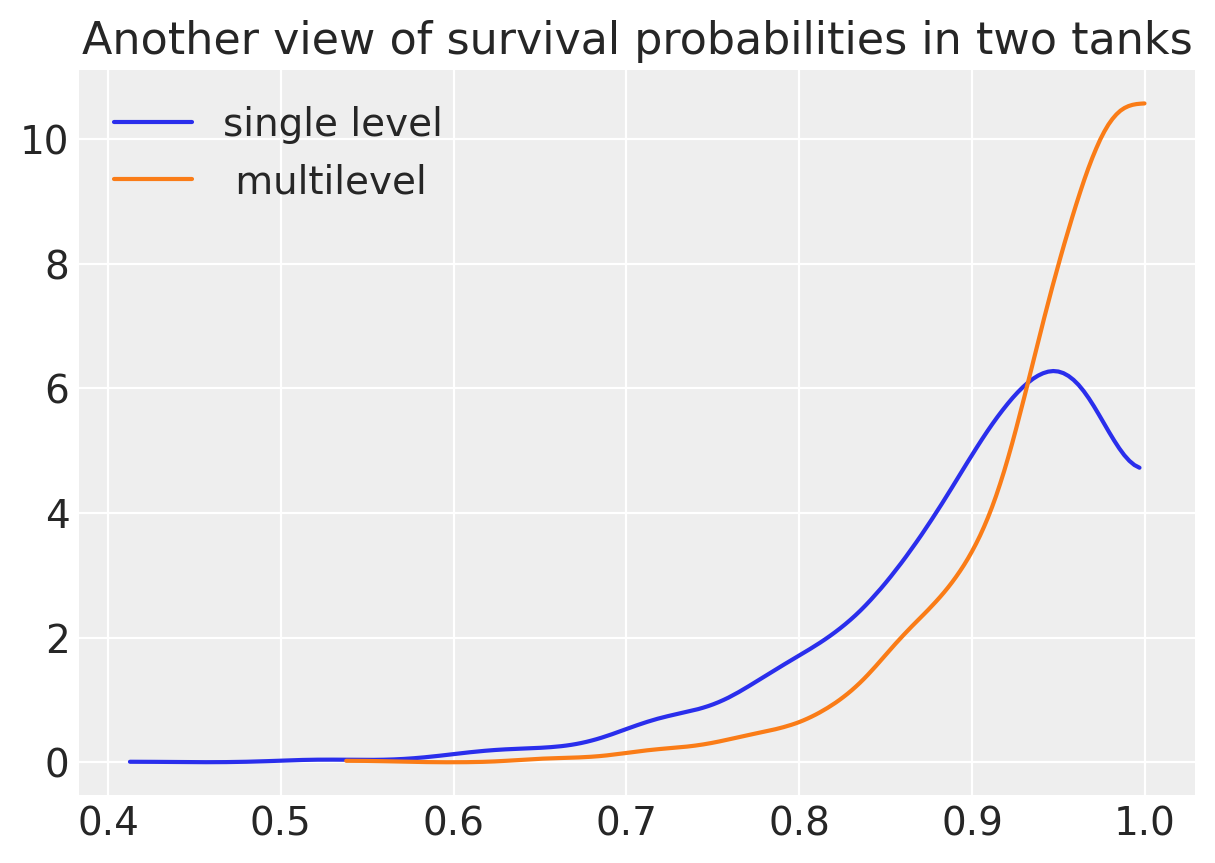

In [12]:
az.plot_dist(logistic(trace_13_1['a'][:,3]),label = 'single level')
az.plot_dist(logistic(trace_13_2['a'][:,3]),label = ' multilevel')
plt.title('Another view of survival probabilities in two tanks')

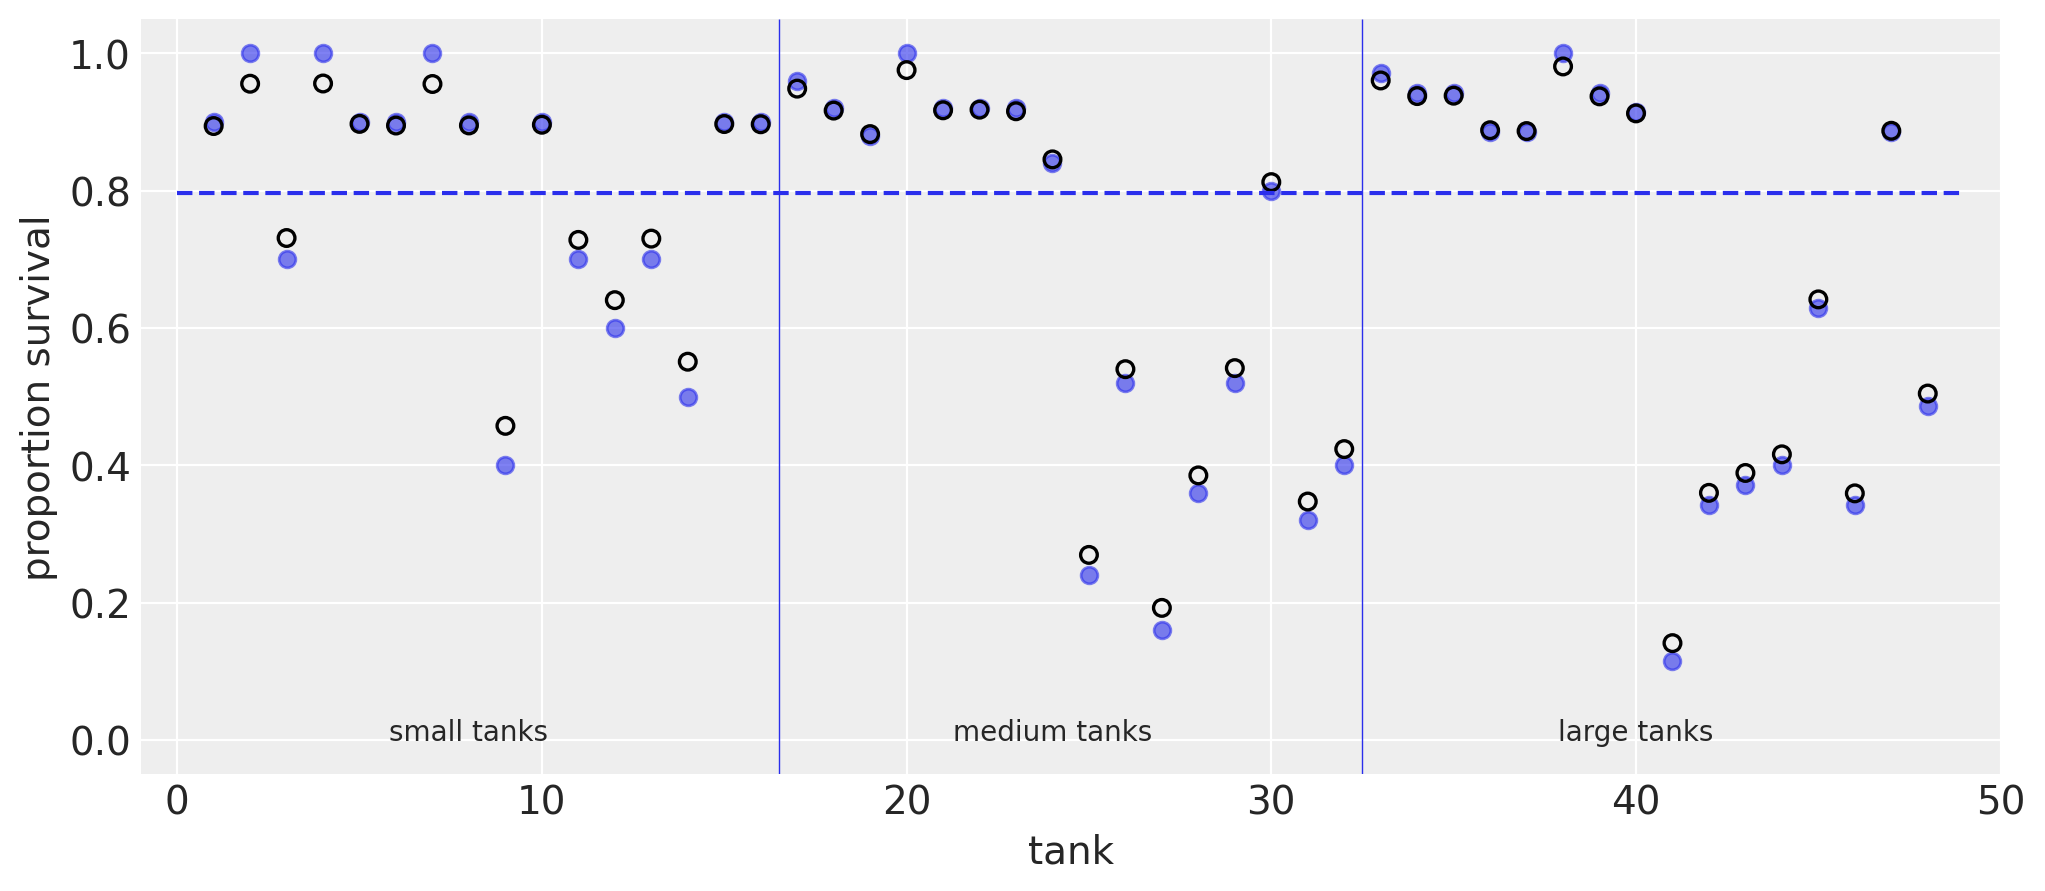

In [13]:
# compute mean intercept for each tank
# also transform to probability with logistic
propsurv = logistic(trace_13_1["a"].mean(0))
propsurv_est = logistic(trace_13_2["a"].mean(0))

_, ax = plt.subplots(1, 1, figsize=(12, 5))

# display raw proportions surviving in each tank
ax.scatter(np.arange(1, 49), d.propsurv, alpha=0.6)

# overlay posterior means
ax.scatter(np.arange(1, 49), propsurv_est, facecolors="none", edgecolors="k", lw=1.2)

# mark posterior mean probability across tanks
ax.hlines(logistic(trace_13_2["a_bar"].mean()), 0, 49, linestyles="--")

# draw vertical dividers between tank densities
ax.vlines([16.5, 32.5], -0.05, 1.05, lw=0.5)
ax.text(8, 0, "small tanks", horizontalalignment="center")
ax.text(16 + 8, 0, "medium tanks", horizontalalignment="center")
ax.text(32 + 8, 0, "large tanks", horizontalalignment="center")

ax.set_xlabel("tank", fontsize=14)
ax.set_ylabel("proportion survival", fontsize=14)
ax.set_xlim(-1, 50)
ax.set_ylim(-0.05, 1.05);

Notes:

Initially i was surprised that this example didnt turn out like it did in the book, however the diffrence was the book used effectively a totally flat prior, while I used the prior from the previous example. It looked like the mutlilevel model shark less than the first model. The benefit of the multilevel model was that it managed to figure out the appropriate SD, while in the first example we just set it as 1.5

What does the inferred population distribution of survival look like? We can visualise it by sampling from the posterior distribution, as usual. First we'll plot 100 Gaussian disributions, one for each of the first 100 samples from the posterior distribution of both alpha and sigma. Then we'll sample 8000 new log-odds survival for individual tanks. The result will be a posterior distribution of variation in survival. Before we do that though, remember that 'sampling' from a posterior distributionis not a simulation of empirical sampling. Its just a convenient way of 

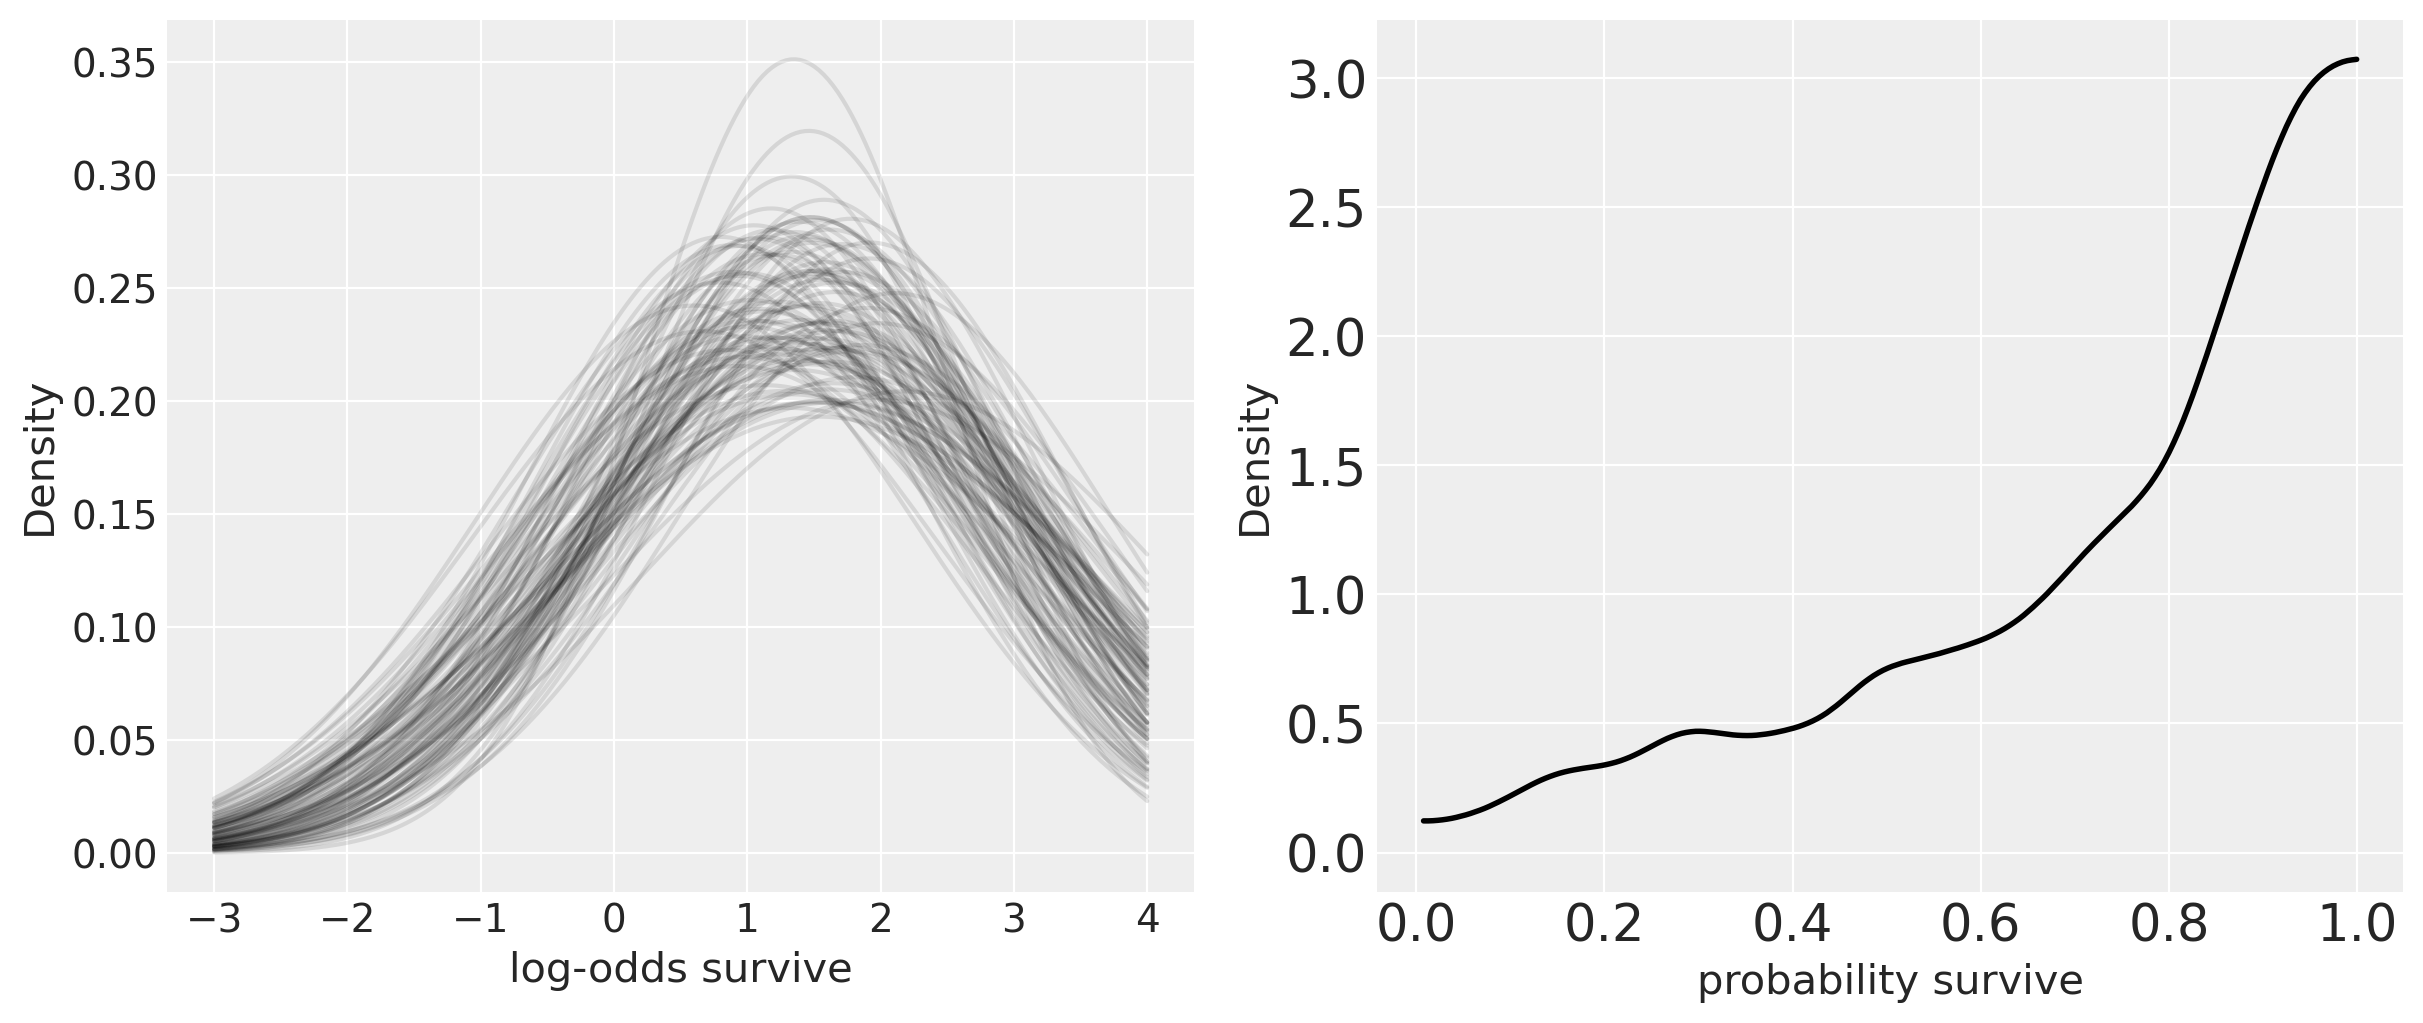

In [14]:
_, ax = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# show first 100 populations in the posterior
xrange = np.linspace(-3, 4, 200)

postcurve = [
    stats.norm.pdf(xrange, loc=trace_13_2["a_bar"][i], scale=trace_13_2["sigma"][i])
    for i in range(100)
]
ax[0].plot(xrange, np.asarray(postcurve).T, alpha=0.1, color="k")
ax[0].set_xlabel("log-odds survive")
ax[0].set_ylabel("Density")

# sample 8000 imaginary tanks from the posterior distribution
sim_tanks = np.random.normal(loc=trace_13_2["a_bar"], scale=trace_13_2["sigma"])

# transform to probability and visualize
az.plot_kde(logistic(sim_tanks), ax=ax[1], plot_kwargs={"color": "k"})
ax[1].set_xlabel("probability survive")
ax[1].set_ylabel("Density");

The results are displayed above, notive that there s uncertainty about both the location alpha, and scale sigma, of the population distribution of log-odds survival. All this uncertainty is propagated into the simulated probabilities of survival.


RETHINKING: ARYING INTERCEPTS AS OVER-DISPERSION
In the previous chapter, the beta-binomial and gamma-poisson models were presented as ways for coping with OVER-DISPERSION of count data. Varying intercepts accomplish the same thing, allowing count outcomes to be over-dispersed. They accomplish this, because when each observed count gets its own uniue intercept, but these intercepts are pooled through a common distribution, the predictions expect over dispersion just like the beta-binmonial or gamma-poisson. Compared to these, a binomial or poisson with varying intercepts on every observed outcome will often be easier to esimtate and easier to extend.


OVERTHINKING: PRIORS FOR VARIANCE COMPONENTS. The examples in this book use weakly regularising exponential priors for variance components, the sigma parameters that estimate the variation across clusters in the data. These exponential priors work very well in routine multilevel modelling. They express only a rough notion of an average standard deviation and regularise towards zero. But there are two common contexts in which they can be problemmatic. First there isnt much information in the data with which to estimate the variance. For example, if you only have 5 clusters, then thats something like thrying to estimate a variance with 5 data points. In that case, you might ned something much more informative. Second, in non-linear models with logit and log links, floor and cieling efects sometimes render extreme values of the variance equaly plausable as more relatistic values. In such cases, the reace plot for the variance parameters may swing around over very large vales. It can do this, because the exponential prior has a long tail. Such values are typically a priori impossible. Often, the chain will still sample validly, but it might be highly inefficient, exhibiting small n_eff values and possibly many divergent transitions

To improve such a model, instead of using exponential priors for the variance components, you can use half-normal priors or some other prior with a thin tail. A half-normal is a normal distribution with all mass above zero. It just cut off below zero.


